In [2]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import pickle
import heapq

In [3]:
# open the text file
with open("TrainingInput.txt", "r", encoding = "utf-8") as f:
        text = f.read()

In [4]:
# split the dataset into words

tokenizer = RegexpTokenizer(r'\w+') # only take alphabets
words = tokenizer.tokenize(text)
print(len(words))


109226


In [5]:
# list out the unique words and put them in the dictionary
unique_words = np.unique(words)
unique_word_index = dict((c,i) for i,c in enumerate(unique_words))
print(len(unique_words))

8912


In [6]:
# Here we will use 5 gram input that is model takes 5 words to predict the 
Batch_size = 5
input_words = []
predicted_word= []

# lets prepare input and the corresponding out
for i in range(len(words) - Batch_size):
    input_words.append(words[i:i+Batch_size])
    predicted_word.append(words[i+Batch_size])

In [10]:
# prepare the one hot encoding arrays that we need to pass to the model for training
X = np.zeros((len(input_words), Batch_size, len(unique_words)), dtype = bool)
Y = np.zeros((len(predicted_word), len(unique_words)), dtype = bool)

# prepare the onehot encoding vectors
for i, tokens in enumerate(input_words): # get the context 
    for j, token in enumerate(tokens): # get each word of the context
        X[i,j,unique_word_index[token]] = 1
    Y[i, unique_word_index[predicted_word[i]]] = 1        

In [11]:
len(X)

109221

In [18]:
# create a model. Here we are doing transfer learning . We are passing our inputs to LSTM . From LSTM we add a dense layer 
# of unique_words . We then apply softmax to get the output word with the highest probability
units = 128 # we are taking 128 units in the LSTM 
model = Sequential()

model.add(LSTM(units, input_shape=(Batch_size, len(unique_words))))
# add a dense layer
model.add(Dense(len(unique_words)))
# add a softmax layer which gives logits for predictions
model.add(Activation('softmax'))

# compile the model using adam optimizer
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

# after trial and error with multiple epochs . noticed that model is overfitting after 6 epochs so setting epoch to 5
# train the model.
history = model.fit(X,Y, validation_split = 0.05 , batch_size = 128 , epochs = 5 , shuffle = True)


Epoch 1/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.0471 - loss: 7.1565 - val_accuracy: 0.0491 - val_loss: 7.8853
Epoch 2/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 80s 98ms/step - accuracy: 0.0518 - loss: 6.4450 - val_accuracy: 0.0683 - val_loss: 7.9252
Epoch 3/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.0870 - loss: 6.1709 - val_accuracy: 0.0815 - val_loss: 7.7659
Epoch 4/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.1135 - loss: 5.8441 - val_accuracy: 0.0910 - val_loss: 7.7109
Epoch 5/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.1357 - loss: 5.5337 - val_accuracy: 0.0943 - val_loss: 7.6781


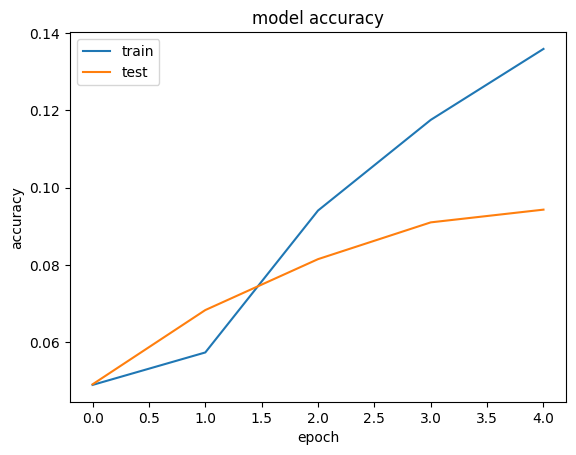

In [20]:
# we can also change the batch size, number of units to LSTM and see if the metrics will imporve. This is for learning so moving ahead with the current results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc = 'upper left')

In [22]:
# save the model for future use
model.save('next_word_predictor.keras')

In [33]:
# lets try to test the model
# first prepare the input to the model. Make sure the input to the model is same as we gave training input
text = "Your life will never be there in the same situation"

# this is the text that we expect to see
# lets crop this text and pass it to the model and see what it gives as output
input_text = "Your life will never be"

# lets tokenize the input
input_text = tokenizer.tokenize(input_text)

x = np.zeros((1, Batch_size, len(unique_words)))
for t, word in enumerate(input_text):
    print(word)
    x[0,t,unique_word_index[word]] = 1


# now pass this to the model

model = load_model('next_word_predictor.keras')
logits = model.predict(x)


Your
life
will
never
be


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


In [34]:
# once we got the logits lets get the probabilities and and get the top 3 words with highest probabilities
preds = np.asarray(logits[0]).astype('float64')
preds = np.log(preds)
exp_preds = np.exp(preds)
probabilities = exp_preds/np.sum(exp_preds)
# indices of top 3 probabilities
indices = heapq.nlargest(3, range(len(probabilities)), probabilities.take)

predicted_words = [unique_words[idx] for idx in indices]
predicted_words

['a', 'to', 'the']

In [35]:
# the word predictions were pretty decent from the model